In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import itertools

In [2]:
np.random.seed(0)

In [3]:
def operators(s):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))

    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1

    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1
            
    return ops

In [4]:
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)

In [5]:
def generate_seqs(n_var,n_seq,n_sample=30,g=1.0):
    samples = np.random.choice([1.0,-1.0],size=(n_seq*n_sample,n_var),replace=True)
    ops = operators(samples)
    n_ops = ops.shape[1]

    w_true = g*(np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))
    #w_true = np.random.normal(0.,g/np.sqrt(n_var),size=n_ops)

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p /= np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    
    return w_true,samples[out_samples] #,p[out_samples],sample_energy[out_samples]

In [6]:
def eps_machine(s,eps_scale=.01,max_iter=151,alpha=0.1):
    MSE = np.zeros(max_iter)
    KL = np.zeros(max_iter)
    E_av = np.zeros(max_iter)
    
    n_seq,n_var = s.shape
    ops = operators(s)
    n_ops = ops.shape[1]
    cov_inv = np.eye(ops.shape[1])

    np.random.seed(13)
    w = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
    for i in range(max_iter): 
        
        #eps_scale = np.random.rand()/np.max([1.,w.max()])
        
        energies_w = energy_ops(ops,w)
        probs_w = np.exp(-energies_w*(1-eps_scale))
        z_data = np.sum(probs_w)
        probs_w /= z_data
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
        
        #if iterate%int(max_iter/5.0)==0:
        E_exp = (probs_w*energies_w).sum()
        KL[i] = -E_exp - np.log(z_data) + np.sum(np.log(np.cosh(w*eps_scale))) + n_var*np.log(2.)
        
        E_av[i] = energies_w.mean()
        MSE[i] = ((w-w_true)**2).mean()
        #print(RMSE[i])
        
        #print(eps_scale,iterate,nplin.norm(w-w_true),RMSE,KL,E_av)

        sec_order = w*eps_scale
        w += alpha*cov_inv.dot((ops_expect_w - sec_order))
        
    #print('final ',eps_scale,iterate,nplin.norm(w-w_true))
    
    return MSE,KL,E_av

In [7]:
max_iter = 100

n_var,n_seq = 20,5000
g = 2.

w_true,seqs = generate_seqs(n_var,n_seq,g=g)

eps_list = [0.1,0.5,0.8]
n_eps = len(eps_list)

#w = np.zeros((n_eps,max_iter,))
MSE = np.zeros((n_eps,max_iter))
KL = np.zeros((n_eps,max_iter))
E_av = np.zeros((n_eps,max_iter))

for i,eps in enumerate(eps_list):     
    print('eps:',eps)
    MSE[i,:],KL[i,:],E_av[i,:] = eps_machine(seqs,eps_scale=eps,max_iter=max_iter)

eps: 0.1
eps: 0.5
eps: 0.8


In [8]:
"""
nx,ny = 3,n_eps
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*3))

#lims = [np.min([w_true, w]), np.max([w_true, w])]

for i,eps in enumerate(eps_list):
    #ax[i,0].set_title('eps=%s'%eps)
    ax[i,0].plot(MSE[i])
    ax[i,1].plot(KL[i])
    ax[i,2].plot(E_av[i])

#ax[i,0].set_ylim([0,0.01])
#ax[i,1].set_ylim([-8,-5])
#ax[i,2].set_ylim([1,2.5])

#ax[0,1].set_ylim([-6.6,-6.1])
#ax[1,1].set_ylim([-6.8,-6.3])
#ax[2,1].set_ylim([-7.2,-7.0])
#ax[3,1].set_ylim([-7.5,-7.3])
    

"""

"\nnx,ny = 3,n_eps\nfig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*3))\n\n#lims = [np.min([w_true, w]), np.max([w_true, w])]\n\nfor i,eps in enumerate(eps_list):\n    #ax[i,0].set_title('eps=%s'%eps)\n    ax[i,0].plot(MSE[i])\n    ax[i,1].plot(KL[i])\n    ax[i,2].plot(E_av[i])\n\n#ax[i,0].set_ylim([0,0.01])\n#ax[i,1].set_ylim([-8,-5])\n#ax[i,2].set_ylim([1,2.5])\n\n#ax[0,1].set_ylim([-6.6,-6.1])\n#ax[1,1].set_ylim([-6.8,-6.3])\n#ax[2,1].set_ylim([-7.2,-7.0])\n#ax[3,1].set_ylim([-7.5,-7.3])\n    \n\n"

Text(0, 0.5, '-E')

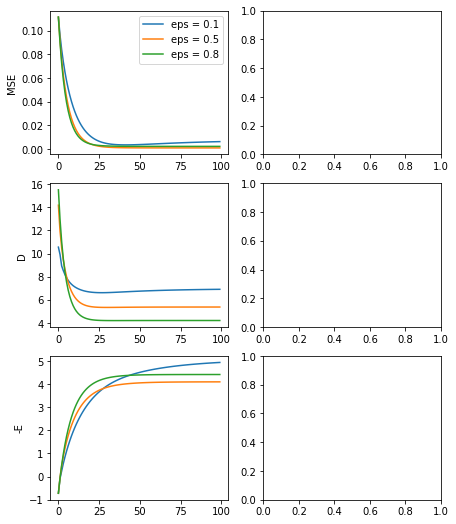

In [9]:
nx,ny = 2,3
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*3))

ax[0,0].plot(MSE[0],label='eps = 0.1')
ax[0,0].plot(MSE[1],label='eps = 0.5')
ax[0,0].plot(MSE[2],label='eps = 0.8')

ax[1,0].plot(KL[0],label='eps = 0.1')
ax[1,0].plot(KL[1],label='eps = 0.5')
ax[1,0].plot(KL[2],label='eps = 0.8')

ax[2,0].plot(E_av[0],label='eps = 0.1')
ax[2,0].plot(E_av[1],label='eps = 0.5')
ax[2,0].plot(E_av[2],label='eps = 0.8')

ax[0,0].legend()
ax[0,0].set_ylabel('MSE')
ax[1,0].set_ylabel('D')
ax[2,0].set_ylabel('-E')

#plt.tight_layout(h_pad=1, w_pad=1.5)
#plt.savefig('fig.pdf', format='pdf', dpi=100)